In [3]:
import pandas as pd

# Define input files
oct_file = r"D:\Sparkathon\Data\phase1_Oct_cleaned_ecommerce_data.csv"
nov_file = r"D:\Sparkathon\Data\phase1_Nov_cleaned_ecommerce_data.csv"

# Columns of interest
use_cols = [
    'event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand',
    'price', 'user_id', 'user_session'
]

# Empty list to hold filtered chunks
filtered_chunks = []

# Define function to read in chunks and filter
def read_and_filter_in_chunks(file_path):
    chunksize = 10**6  # You can adjust this based on your system’s memory
    for chunk in pd.read_csv(file_path, usecols=use_cols, parse_dates=['event_time'], chunksize=chunksize):
        # Filter only purchase events
        chunk = chunk[chunk['event_type'] == 'purchase'].copy()
        # Add event_date column
        chunk['event_date'] = chunk['event_time'].dt.date
        filtered_chunks.append(chunk)

# Read both Oct and Nov data
read_and_filter_in_chunks(oct_file)
read_and_filter_in_chunks(nov_file)

# Combine all filtered data
purchase_data = pd.concat(filtered_chunks, ignore_index=True)

# Save to disk if needed
purchase_data.to_csv(r"D:\Sparkathon\Data\phase4_combined_purchases.csv", index=False)
print("Purchase data loaded and saved.")


Purchase data loaded and saved.


In [5]:
import pandas as pd

# Load concatenated raw data
df = pd.read_csv(r"D:\Sparkathon\Data\phase4_combined_purchases.csv", parse_dates=['event_time'])

# Convert event_time to just date (yyyy-mm-dd)
df['event_date'] = df['event_time'].dt.date

# Keep only purchase events
purchases = df[df['event_type'] == 'purchase'].copy()

# Drop rows with missing category_code or category_id (optional but recommended)
purchases = purchases.dropna(subset=['category_code', 'category_id'])

# Aggregate: Count of purchases per day per category
daily_demand = purchases.groupby(['category_code', 'category_id', 'event_date'])['event_type'].count().reset_index()

# Rename columns to match Prophet expectations (ds and y)
daily_demand.rename(columns={
    'event_date': 'ds',
    'event_type': 'y'
}, inplace=True)

# Save for future steps
daily_demand.to_csv("D:/Sparkathon/Data/aggregated_category_demand.csv", index=False)

print("Aggregated daily category demand shape:", daily_demand.shape)
print(daily_demand.head())


Aggregated daily category demand shape: (24360, 4)
  category_code          category_id          ds   y
0       Unknown  2053013552259662037  2019-10-01  89
1       Unknown  2053013552259662037  2019-10-02  76
2       Unknown  2053013552259662037  2019-10-03  82
3       Unknown  2053013552259662037  2019-10-04  71
4       Unknown  2053013552259662037  2019-10-05  52


In [11]:
import pandas as pd

# Load the CSV without date parsing
df = pd.read_csv(r"D:\Sparkathon\Data\aggregated_category_demand.csv")

# Convert category_code to lowercase (to catch 'Unknown', 'UNKNOWN', etc.)
df['category_code'] = df['category_code'].astype(str).str.lower()

# Filter rows where category_code is 'unknown'
unknown_rows = df[df['category_code'] == 'unknown']

# Show count
print("Number of rows with category_code as 'unknown':", len(unknown_rows))

# Optional: percentage
total_rows = len(df)
percentage_unknown = (len(unknown_rows) / total_rows) * 100
print(f"Percentage of unknown category_code: {percentage_unknown:.2f}%")

# Show sample
print("\nSample rows with unknown category_code:")
print(unknown_rows.head())


Number of rows with category_code as 'unknown': 14319
Percentage of unknown category_code: 58.78%

Sample rows with unknown category_code:
  category_code          category_id          ds   y
0       unknown  2053013552259662037  2019-10-01  89
1       unknown  2053013552259662037  2019-10-02  76
2       unknown  2053013552259662037  2019-10-03  82
3       unknown  2053013552259662037  2019-10-04  71
4       unknown  2053013552259662037  2019-10-05  52


16:10:13 - cmdstanpy - INFO - Chain [1] start processing


Known categories retained: 10041 rows


16:10:13 - cmdstanpy - INFO - Chain [1] done processing
16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
16:10:15 - cmdstanpy - INFO - Chain [1] start processing
16:10:15 - cmdstanpy - INFO - Chain [1] done processing
16:10:15 - cmdstanpy - INFO - Chain [1] start processing
16:10:15 - cmdstanpy - INFO - Chain [1] done processing
16:10:15 - cmdstanpy - INFO - Chain [1] start processing
16:10:15 - cmdstanpy - INFO - Chain [1] done processing
16:10:15 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
16:10:16 - cmdstanpy - INFO - Chain [1] 


📌 Summary Sample:
                   category_code         category_id  avg_forecast_demand  last_7d_avg_before_dec dominant_alert_status
          electronics.smartphone 2053013555631882655             15264.01                11564.57                Stable
     electronics.audio.headphone 2053013554658804075              1780.59                 1211.29                Stable
            electronics.video.tv 2053013554415534427              1343.88                  802.29        Overstock Risk
   appliances.environment.vacuum 2053013565983425517               820.78                  420.14        Overstock Risk
       appliances.kitchen.washer 2053013563810775923               814.52                  450.43        Overstock Risk
              computers.notebook 2053013558920217191               732.39                  492.86                Stable
              electronics.clocks 2053013553341792533               683.66                  450.43                Stable
appliances.kitchen.re

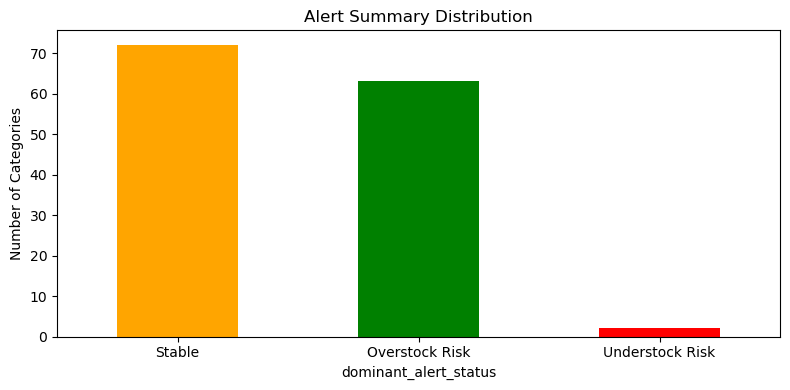

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from prophet import Prophet

# === STEP 1: Load and Clean Data ===
data = pd.read_csv(r"D:\Sparkathon\Data\aggregated_category_demand.csv", parse_dates=["ds"])

# Remove unknowns
data = data[data["category_code"].str.lower() != "unknown"]
print(f"Known categories retained: {len(data)} rows")

# Create output dir
output_dir = "phase4_outputs"
os.makedirs(output_dir, exist_ok=True)

# === STEP 2: Group by category_code & category_id ===
grouped = data.groupby(["category_code", "category_id"])

alert_summary = []

for (category_code, category_id), group in grouped:
    if len(group) < 45:
        continue

    group = group.sort_values("ds").copy()
    group = group[["ds", "y"]]

    train = group[group["ds"] <= "2019-11-30"]
    if len(train) < 30:
        continue

    # === STEP 3: Train Prophet ===
    model = Prophet(daily_seasonality=True)
    model.fit(train)

    # === STEP 4: Forecast December ===
    future = model.make_future_dataframe(periods=31)
    forecast = model.predict(future)

    forecast_dec = forecast[(forecast["ds"] >= "2019-12-01") & (forecast["ds"] <= "2019-12-31")].copy()
    forecast_dec["category_code"] = category_code
    forecast_dec["category_id"] = category_id
    forecast_dec["cumulative_forecast"] = forecast_dec["yhat"].cumsum()

    forecast_clean = forecast_dec[["ds", "category_code", "category_id", "yhat", "cumulative_forecast"]].rename(
        columns={"ds": "date", "yhat": "predicted_demand"}
    )

    # === STEP 5: Alerts ===
    last_7d_avg = train["y"].tail(7).mean()

    def alert_rule(x):
        if x > 1.5 * last_7d_avg:
            return "Overstock Risk"
        elif x < 0.5 * last_7d_avg:
            return "Understock Risk"
        else:
            return "Stable"

    forecast_clean["alert"] = forecast_clean["predicted_demand"].apply(alert_rule)

    dominant_alert = forecast_clean["alert"].mode().iloc[0]

    # Save forecast
    fname = f"{category_code.replace('/', '_')}_{category_id}.csv"
    forecast_clean.to_csv(os.path.join(output_dir, fname), index=False)

    # Save summary
    alert_summary.append({
        "category_code": category_code,
        "category_id": category_id,
        "avg_forecast_demand": round(forecast_clean["predicted_demand"].mean(), 2),
        "last_7d_avg_before_dec": round(last_7d_avg, 2),
        "dominant_alert_status": dominant_alert
    })

# === STEP 6: Summary & Save ===
summary_df = pd.DataFrame(alert_summary)
summary_df = summary_df.sort_values("avg_forecast_demand", ascending=False)
summary_path = os.path.join(output_dir, "phase4_alert_summary.csv")
summary_df.to_csv(summary_path, index=False)

print("\n📌 Summary Sample:")
print(summary_df.head(10).to_string(index=False))

# === STEP 7: Visualize Alert Distribution ===
plt.figure(figsize=(8, 4))
alert_counts = summary_df["dominant_alert_status"].value_counts()
alert_counts.plot(kind="bar", color=["orange", "green", "red"])
plt.title("Alert Summary Distribution")
plt.ylabel("Number of Categories")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "alert_summary_plot.png"))
plt.show()
